# Dublin Bikes Data Analysis

In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

In [40]:
# Combine the dataframe together into one
data1 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20190401_20190701.csv')
data2 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20190701_20191001.csv')
#data3 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20191001_20200101.csv')
#data4 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20200101_20200401.csv')
#data5 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20200401_20200701.csv')
#data6 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20200701_20201001.csv')
#data7 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20210101_20210401.csv')
#data8 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20210401_20210701.csv')
#data9 = pd.read_csv('/Users/suryaravindran/Downloads/dublinbikes_20210701_20211001.csv')

#merge data into one table
data = pd.concat([data1,data2])
#pd.concat([data2, data3, data4,data5,data6,data7,data8,data9])

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5327874 entries, 0 to 2974313
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   STATION ID             int64  
 1   TIME                   object 
 2   LAST UPDATED           object 
 3   NAME                   object 
 4   BIKE STANDS            int64  
 5   AVAILABLE BIKE STANDS  int64  
 6   AVAILABLE BIKES        int64  
 7   STATUS                 object 
 8   ADDRESS                object 
 9   LATITUDE               float64
 10  LONGITUDE              float64
dtypes: float64(2), int64(4), object(5)
memory usage: 487.8+ MB


In [42]:
data

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
0,2,2019-04-01 00:00:06,2019-03-31 23:52:05,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
1,2,2019-04-01 00:05:04,2019-04-01 00:02:13,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
2,2,2019-04-01 00:10:04,2019-04-01 00:02:13,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
3,2,2019-04-01 00:15:03,2019-04-01 00:12:21,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
4,2,2019-04-01 00:20:03,2019-04-01 00:12:21,BLESSINGTON STREET,20,14,6,Open,Blessington Street,53.356770,-6.268140
...,...,...,...,...,...,...,...,...,...,...,...
2974309,115,2019-10-01 23:35:02,2019-10-01 23:32:20,KILLARNEY STREET,30,0,30,Open,Killarney Street,53.354843,-6.247579
2974310,115,2019-10-01 23:40:02,2019-10-01 23:32:20,KILLARNEY STREET,30,0,30,Open,Killarney Street,53.354843,-6.247579
2974311,115,2019-10-01 23:45:02,2019-10-01 23:42:29,KILLARNEY STREET,30,0,30,Open,Killarney Street,53.354843,-6.247579
2974312,115,2019-10-01 23:50:04,2019-10-01 23:42:29,KILLARNEY STREET,30,0,30,Open,Killarney Street,53.354843,-6.247579


In [43]:
data['LAST UPDATED']=data['LAST UPDATED'].astype(str)

In [44]:
data['TIME']=data['TIME'].astype(str)

In [45]:
#merge data into one table
data = data[data['STATUS'] == 'Open']
data = data[(data['LAST UPDATED'] >= '2019-07-01') & (data['LAST UPDATED'] < '2021-10-01')]
#data = data[(data['LAST UPDATED'] < '2019-12-01') | (data['LAST UPDATED'] >= '2020-02-01')]

#remove rows where no update actually occurs
data = data.drop(['TIME'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)


#get date and time columns
data['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["LAST UPDATED"]]
data['LAST UPDATED'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['DATE'] = [dt.datetime.date(d) for d in data['DATETIME']] 

#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['DAY_NUMBER'] = data.DATETIME.dt.dayofweek
data['DAY_TYPE'] = np.where(data['DAY_NUMBER'] <= 4, 'Weekday', (np.where(data['DAY_NUMBER'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "


data["TIME_TYPE"] = data['DATETIME'].apply(bin_time)
data['HOUR'] = data['DATETIME'].dt.hour
data['MONTH'] = data['DATETIME'].dt.month
data['CLUSTER_GROUP'] = data['TIME_TYPE'] + data['DAY_TYPE']

data.sample(5)



,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,DATE,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
555685,28,20:21:15,MOUNTJOY SQUARE WEST,30,15,15,Open,Mountjoy Square West,53.356300,-6.258586,...,2019-07-18,0.500000,0,0,3,Weekday,8PM-11PM,20,7,8PM-11PM Weekday
1417168,21,18:03:35,LEINSTER STREET SOUTH,30,2,28,Open,Leinster Street South,53.342178,-6.254485,...,2019-08-14,0.933333,0,0,2,Weekday,4PM-7PM,18,8,4PM-7PM Weekday
2632296,36,10:26:36,ST. STEPHEN'S GREEN EAST,40,23,17,Open,St. Stephen's Green East,53.337826,-6.256035,...,2019-09-21,0.425000,0,0,5,Saturday,6AM-10AM,10,9,6AM-10AM Saturday
2937121,97,20:29:30,KILMAINHAM GAOL,40,6,34,Open,Kilmainham Gaol,53.342113,-6.310015,...,2019-09-30,0.850000,0,0,0,Weekday,8PM-11PM,20,9,8PM-11PM Weekday
917442,63,14:10:04,FENIAN STREET,35,5,30,Open,Fenian Street,53.341427,-6.246720,...,2019-07-29,0.857143,0,0,0,Weekday,11AM-3PM,14,7,11AM-3PM Weekday


In [46]:
data['YEAR'] = data['DATETIME'].dt.year

In [62]:
data['date_for_merge'] = data['DATETIME'].dt.round('H')

In [47]:
def C19(x):
    if x > 2019:
        return 0
    else:
        return 1
data["COVID_INDICATOR"] = data['YEAR'].apply(C19)

In [48]:
data.describe()

,STATION ID,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,LATITUDE,LONGITUDE,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,HOUR,MONTH,YEAR,COVID_INDICATOR
count,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1.879353e+06,1879353.0,1879353.0
mean,5.757620e+01,3.197410e+01,1.979116e+01,1.208060e+01,5.334541e+01,-6.264064e+00,3.792343e-01,1.534581e-01,5.211953e-02,2.884601e+00,1.177822e+01,8.000155e+00,2019.0,1.0
std,3.291098e+01,7.602420e+00,1.233247e+01,1.147133e+01,7.562220e-03,1.789092e-02,3.413272e-01,3.604286e-01,2.222681e-01,1.981165e+00,6.582189e+00,8.359619e-01,0.0,0.0
min,2.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,5.333009e+01,-6.310015e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,2019.0,1.0
25%,2.900000e+01,2.900000e+01,1.000000e+01,2.000000e+00,5.333976e+01,-6.275071e+00,6.250000e-02,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,7.000000e+00,2019.0,1.0
50%,5.700000e+01,3.000000e+01,2.000000e+01,9.000000e+00,5.334460e+01,-6.262980e+00,2.758621e-01,0.000000e+00,0.000000e+00,3.000000e+00,1.200000e+01,8.000000e+00,2019.0,1.0
75%,8.600000e+01,4.000000e+01,3.000000e+01,2.000000e+01,5.335029e+01,-6.251557e+00,6.750000e-01,0.000000e+00,0.000000e+00,5.000000e+00,1.700000e+01,9.000000e+00,2019.0,1.0
max,1.150000e+02,4.000000e+01,4.300000e+01,4.000000e+01,5.335997e+01,-6.230852e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,2.300000e+01,1.000000e+01,2019.0,1.0


                       STATION ID  BIKE STANDS  AVAILABLE BIKE STANDS  \
STATION ID               1.000000     0.562615               0.240159   
BIKE STANDS              0.562615     1.000000               0.411721   
AVAILABLE BIKE STANDS    0.240159     0.411721               1.000000   
AVAILABLE BIKES          0.115113     0.220191              -0.797066   
LATITUDE                 0.231457    -0.084054              -0.009152   
LONGITUDE               -0.252453    -0.017979               0.010625   
OCCUPANCY_PCT           -0.013556    -0.017372              -0.893291   
FULL                     0.010833    -0.022384               0.404954   
EMPTY                    0.031986    -0.023867              -0.376309   
DAY_NUMBER               0.005161    -0.002018              -0.016732   
HOUR                    -0.009933    -0.005678               0.003152   
MONTH                   -0.004240    -0.001440              -0.011463   
YEAR                          NaN          NaN     

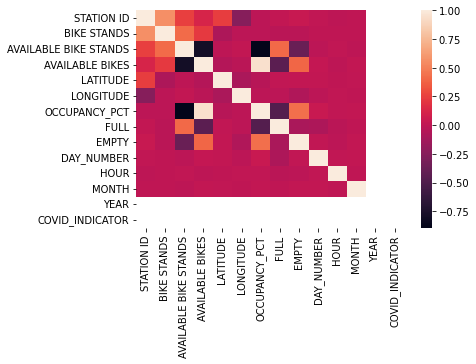

In [49]:
CorrMatrix=data.corr()
print(CorrMatrix)
sns.heatmap(CorrMatrix)
plt.show()

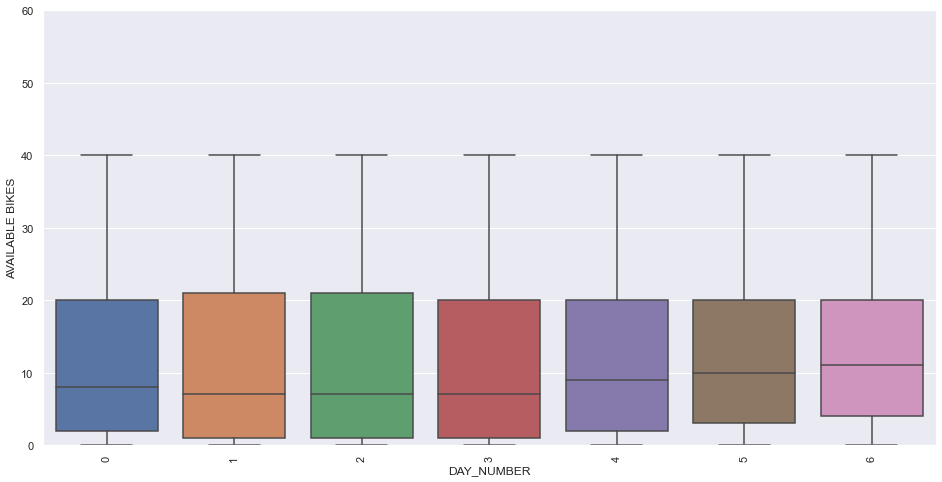

In [79]:
var = 'DAY_NUMBER'
df = pd.concat([data['AVAILABLE BIKES'], data[var1]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="AVAILABLE BIKES", data=df)
fig.axis(ymin=0, ymax=60);
plt.xticks(rotation=90);

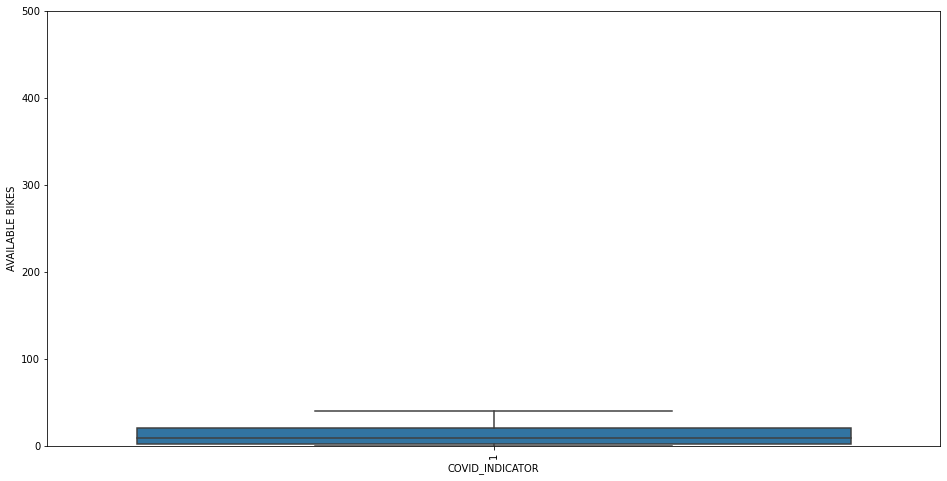

In [57]:
var = 'COVID_INDICATOR'
df1 = pd.concat([data['AVAILABLE BIKES'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="AVAILABLE BIKES", data=df1)
fig.axis(ymin=0, ymax=500);
plt.xticks(rotation=90);

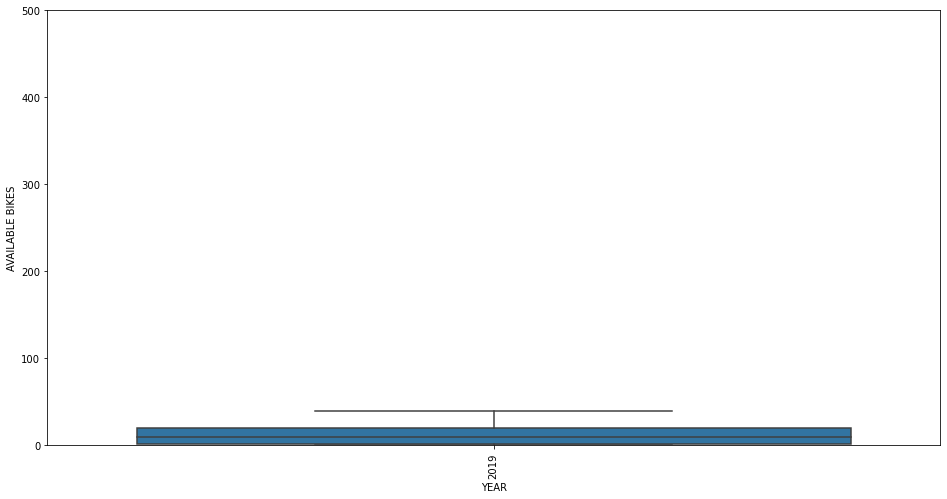

In [58]:
var = 'YEAR'
df2 = pd.concat([data['AVAILABLE BIKES'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="AVAILABLE BIKES", data=df2)
fig.axis(ymin=0, ymax=500);
plt.xticks(rotation=90);

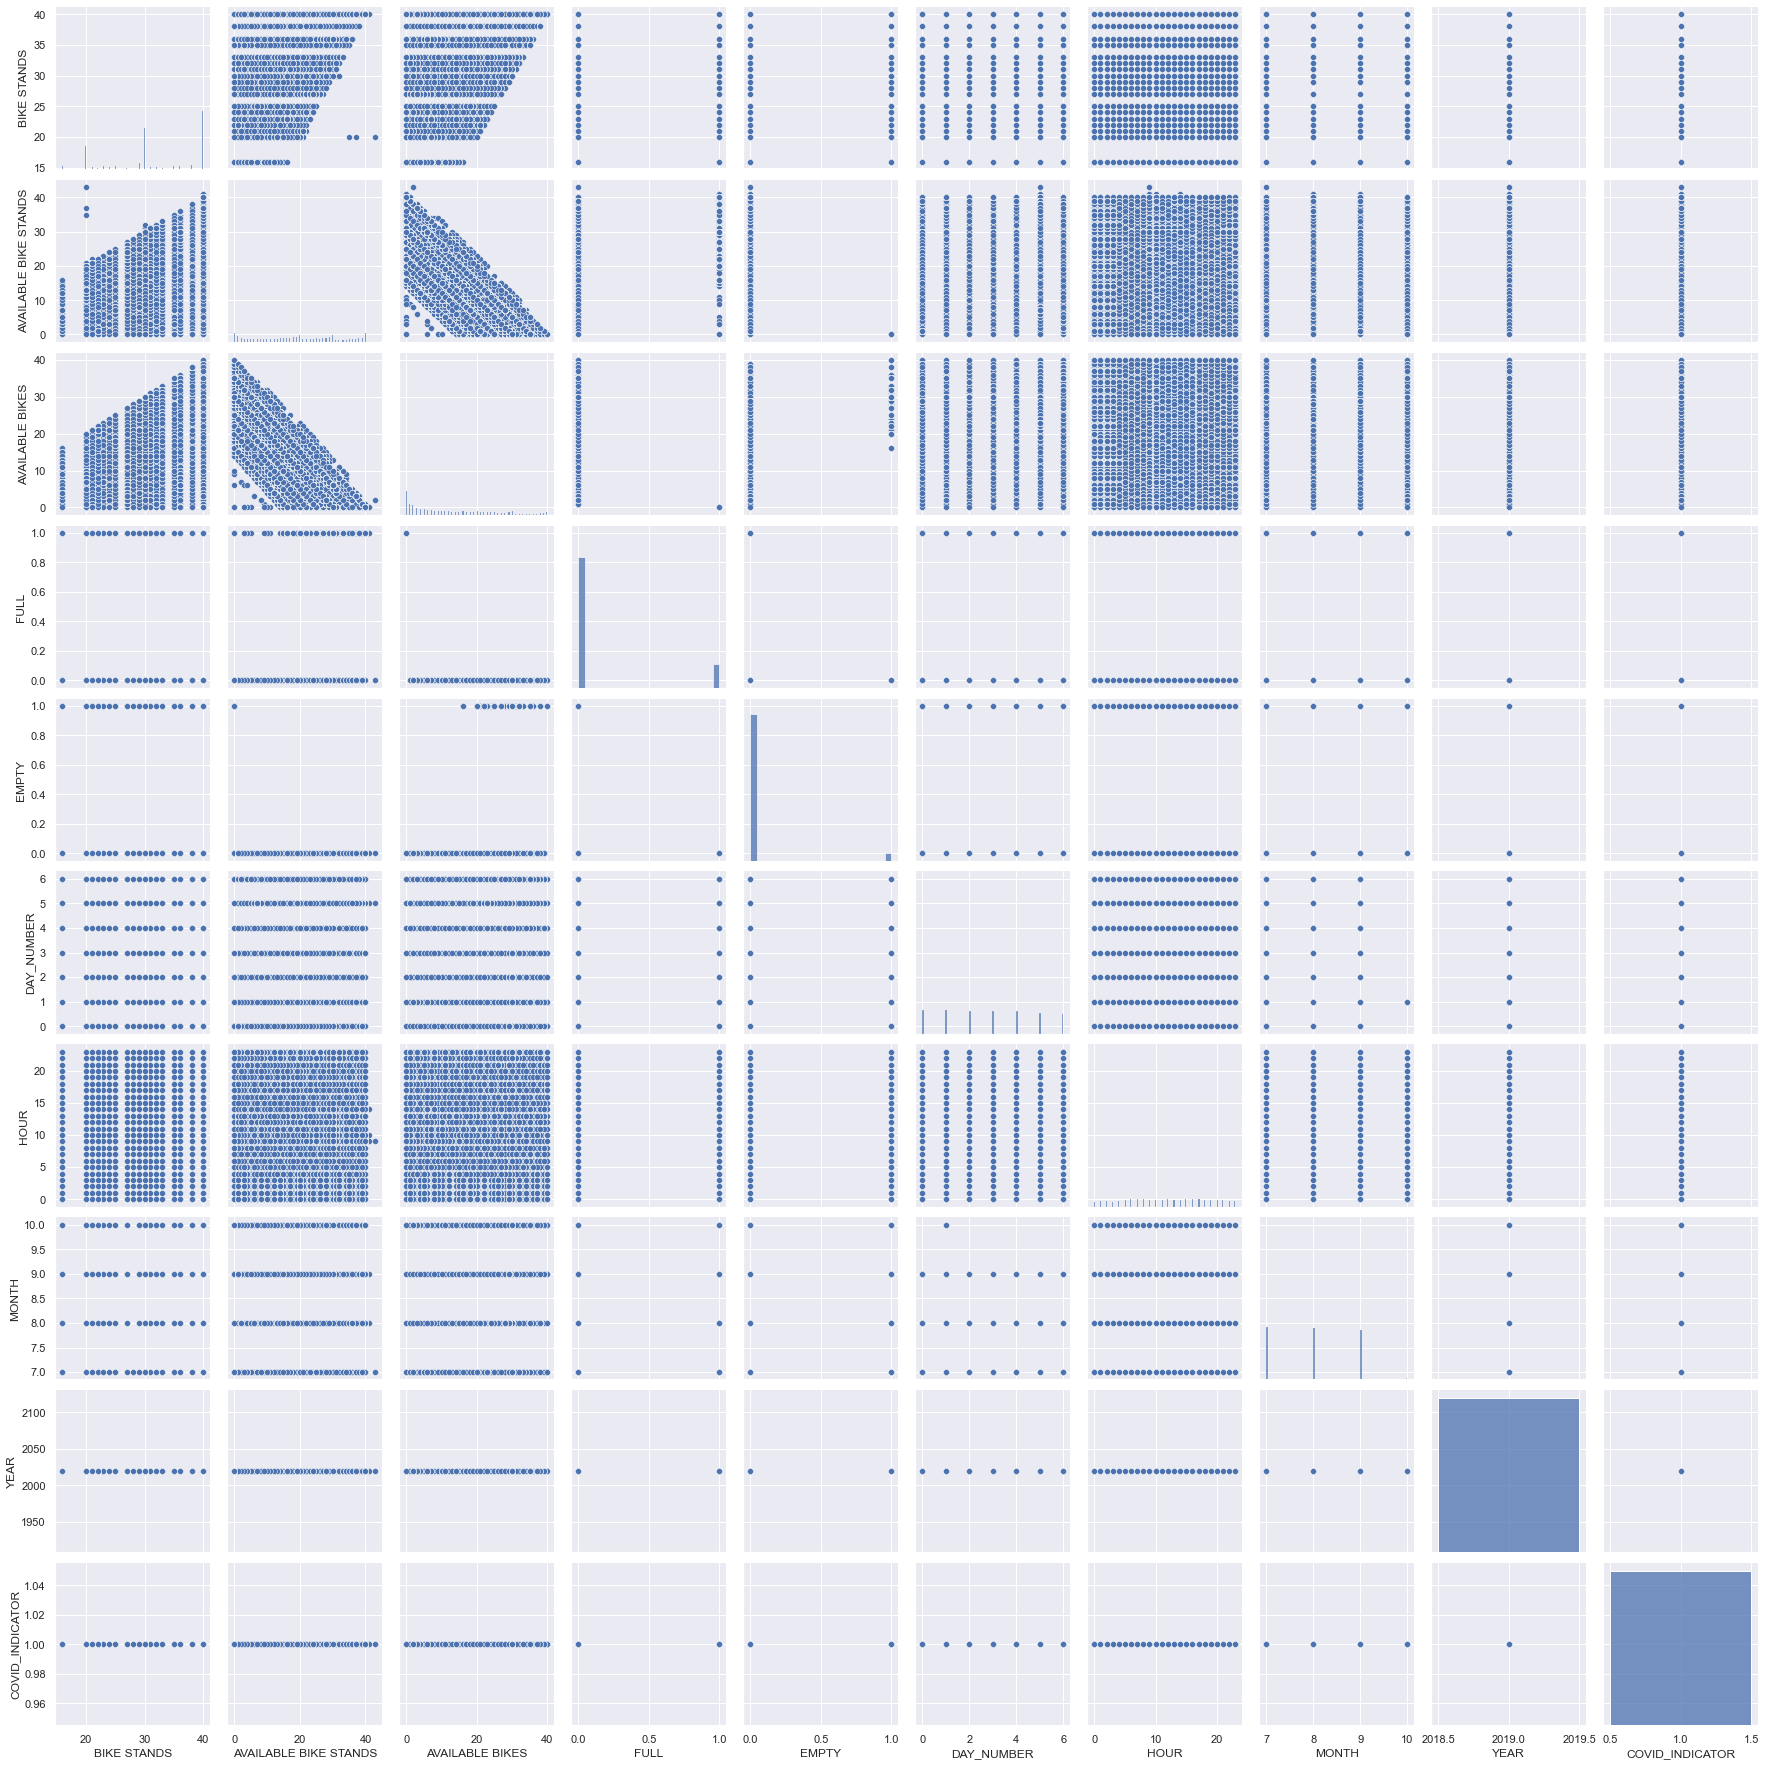

In [59]:
#scatterplot
sns.set()
cols = ['BIKE STANDS','AVAILABLE BIKE STANDS','AVAILABLE BIKES','FULL','EMPTY','DAY_NUMBER','HOUR','MONTH','YEAR','COVID_INDICATOR']
sns.pairplot(data[cols], size = 2.5)
plt.show();

In [60]:
### Prepare Weather Data

weather = pd.read_csv('hly175.csv')
weather['date'] = [dt.datetime.strptime(d, "%m/%d/%Y %H:%M") for d in weather['date'] ]
weather['date_for_merge'] = weather['date'].dt.round('H')
weather = weather[(weather['date'] >= '2019-04-01') & (weather['date'] < '2020-04-02')]
weather = weather[['date_for_merge', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']]
weather['rain'] = weather['rain'].astype(float)
weather['temp'] = weather['temp'].astype(float)

#add binary variables to note wet/dry weather and hot or not days (temperature)
weather['dry'] = np.where(weather['rain'] > 0.0, 1, 0)
weather['warm'] = np.where(weather['temp'] > 18.0, 1, 0)
weather.sample(5)


,date_for_merge,rain,temp,wetb,dewpt,vappr,rhum,msl,dry,warm
117879,2020-02-27 16:00:00,0.0,7.3,4.1,-1.2,5.6,54,1008.7,0,0
118218,2020-03-12 19:00:00,0.6,4.6,3.7,2.4,7.3,85,1007.1,1,0
114956,2019-10-28 21:00:00,0.0,8.0,5.3,1.3,6.7,62,1026.5,0,0
117375,2020-02-06 16:00:00,0.0,7.8,5.7,2.8,7.5,70,1026.0,0,0
116731,2020-01-10 20:00:00,0.0,9.3,8.1,6.8,9.9,84,1016.0,0,0


In [63]:
#merge weather with bikes data
merged_data = pd.merge(data,weather, on ='date_for_merge', how = 'left')

In [64]:
# identify bike arrivals and bike departures
merged_data['BIKE_ARR_DEP'] = merged_data.groupby('STATION ID')['AVAILABLE BIKE STANDS'].diff(-1)
merged_data['BIKE_ARR'] = np.where(merged_data['BIKE_ARR_DEP'] > 0, merged_data['BIKE_ARR_DEP'], 0)
merged_data['BIKE_DEP'] = np.where(merged_data['BIKE_ARR_DEP'] < 0, merged_data['BIKE_ARR_DEP'], 0)
merged_data['ACTIVITY_TYPE'] = np.where(abs(merged_data['BIKE_ARR_DEP']) >= 10, "REBALANCING", "RENTAL")
merged_data['IMBALANCED'] = np.where(merged_data['OCCUPANCY_PCT'] < .1, 1, 
                                   np.where(merged_data['OCCUPANCY_PCT'] > .9, 1,0 ))

In [65]:
# Identify days with rebalancing
merged_data['REBALANCING'] = np.where(merged_data['ACTIVITY_TYPE'] == 'REBALANCING', 1,0)
merged_data['JOIN_ON'] = merged_data['STATION ID'].apply(str)  + (merged_data['DATE']).apply(str) 
join_table= merged_data.groupby(['JOIN_ON'])['REBALANCING'].sum()
merged_data = merged_data.drop(['REBALANCING'], axis = 1)
join_table = join_table.to_frame()
join_table =join_table.reset_index()
merged_data = pd.merge(merged_data, join_table, on = 'JOIN_ON', how = 'left')
merged_data = merged_data.drop(['JOIN_ON'], axis = 1)

merged_data.sample(5)

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,rhum,msl,dry,warm,BIKE_ARR_DEP,BIKE_ARR,BIKE_DEP,ACTIVITY_TYPE,IMBALANCED,REBALANCING
33623,69,09:07:52,GRAND CANAL DOCK,40,11,29,Open,Grand Canal Dock,53.342636,-6.238695,...,57,1028.1,0,0,0.0,0.0,0.0,RENTAL,0,2
29961,50,18:32:59,GEORGES LANE,40,5,35,Open,George's Lane,53.350231,-6.279696,...,62,1028.3,0,0,0.0,0.0,0.0,RENTAL,0,0
1729391,49,08:58:09,GUILD STREET,40,11,29,Open,Guild Street,53.347931,-6.240928,...,97,996.1,0,0,1.0,1.0,0.0,RENTAL,0,0
1292911,71,09:11:15,KEVIN STREET,40,38,2,Open,Kevin Street,53.337757,-6.267699,...,74,1020.5,0,0,0.0,0.0,0.0,RENTAL,1,0
296930,52,07:44:30,YORK STREET EAST,32,19,13,Open,York Street East,53.338757,-6.262003,...,73,1021.8,0,0,1.0,1.0,0.0,RENTAL,0,1


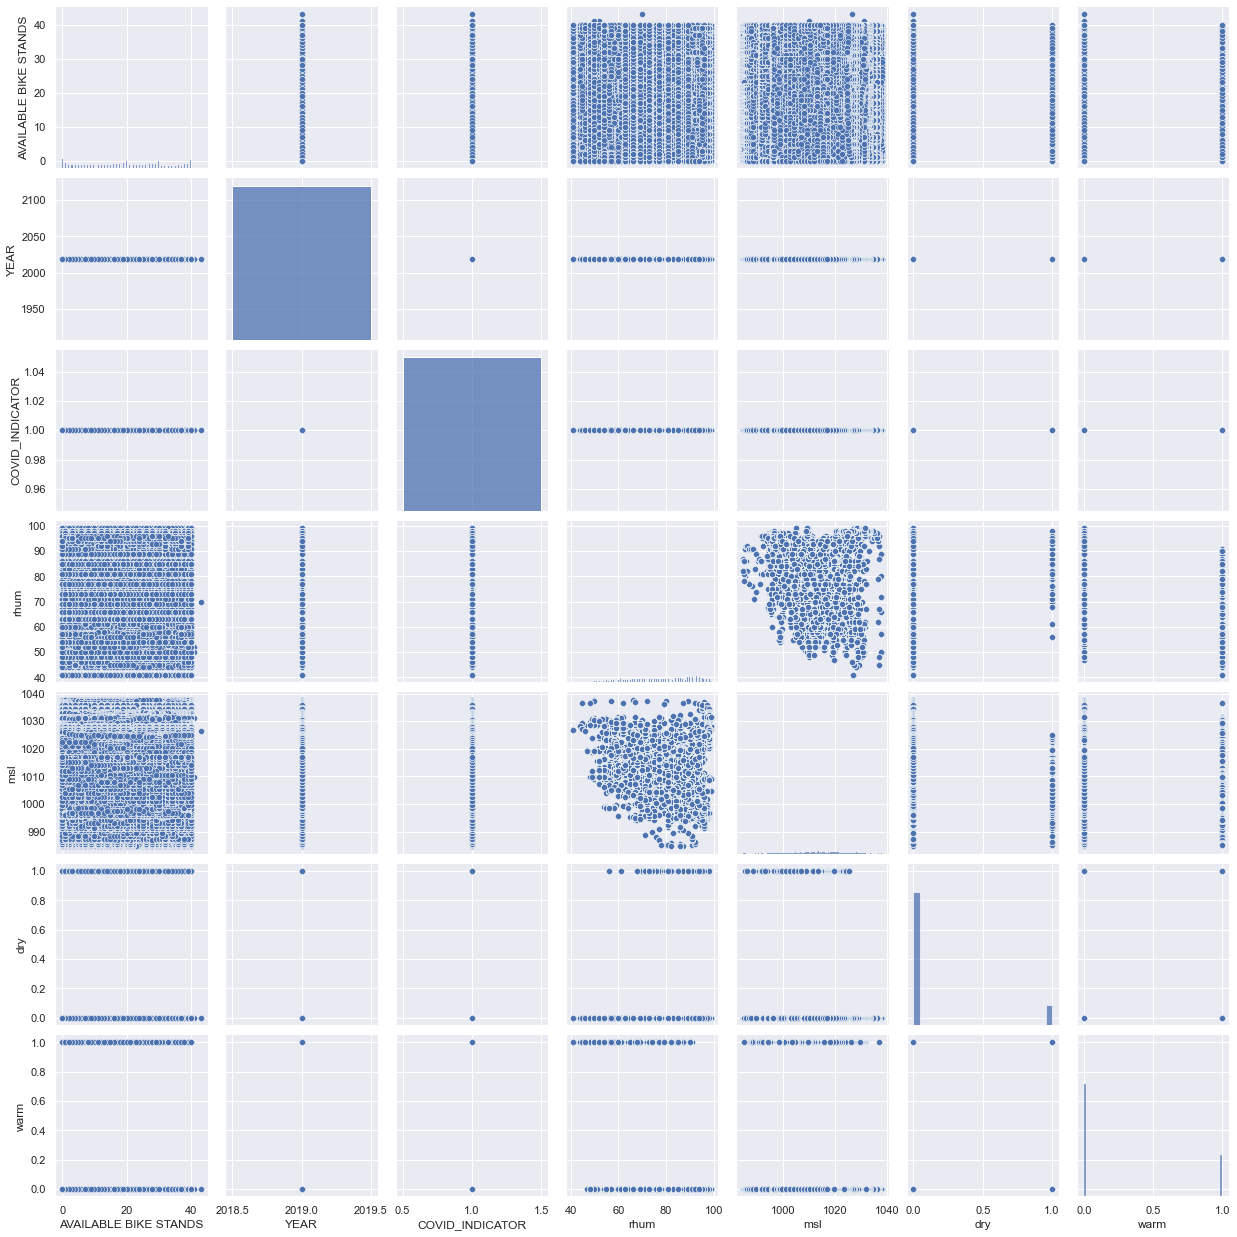

In [66]:
#scatterplot
sns.set()
cols = ['AVAILABLE BIKE STANDS','YEAR','COVID_INDICATOR','rhum','msl','dry','warm']
sns.pairplot(merged_data[cols], size = 2.5)
plt.show();

<AxesSubplot:xlabel='Date'>

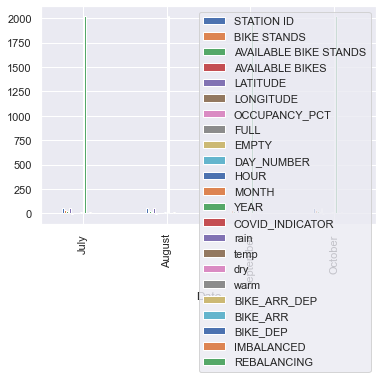

In [69]:
merged_data['Date'] = pd.to_datetime(merged_data['date_for_merge'], dayfirst=True)
merged_data.groupby([merged_data['Date'].dt.month_name()], sort=False).mean('AVAILABLE BIKES').plot(kind='bar')

In [70]:
merged_data.reset_index().plot(
    x="date_for_merge", y=["AVAILABLE BIKES"], kind="bar")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f964090e160> (for post_execute):


KeyboardInterrupt: 

In [72]:
colordict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.5)
for LATITUDE, LONGITUDE, Cluster in zip(merged_data['LATITUDE'],merged_data['LONGITUDE'],merged_data['AVAILABLE BIKES']):
    folium.CircleMarker(
        [LATITUDE, LONGITUDE],
        color = 'b',
        radius = 8,
        fill_color='blue',
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map

In [75]:
heatmap= merged_data.pivot_table(index='DAY_NUMBER',columns='HOUR',values='AVAILABLE BIKES')

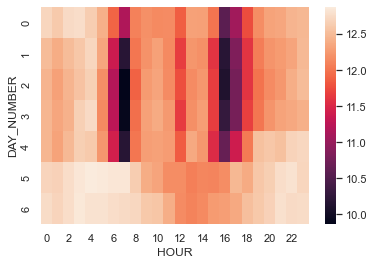

In [76]:
sns.heatmap(heatmap)
plt.show()

In [80]:
dublin_map